In [1]:
import torch
import tqdm
import numpy as np
from sklearn.manifold import TSNE
from torchvision import datasets, models, transforms
from vgg_face import *
from FAUDataset import *
import matplotlib.pyplot as plt



c:\Users\Yuan\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Yuan\anaconda3\envs\pytorch\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [70]:
def get_list(contents, item):
    list = []
    for i in range(len(contents)):
        if item in contents[i]:
            list.append(float(contents[i][contents[i].index(':')+1:]))
    return list


def plot_total_loss(path, title):
    with open(path) as f:
        contents = f.readlines()
    train_loss_list = get_list(contents, 'train_loss')
    test_loss_list = get_list(contents, 'test_loss')
    plt.plot(train_loss_list, label='train')
    plt.plot(test_loss_list, label='test')
    plt.ylabel('Total Loss')
    plt.title(title) # General MSE Loss
    plt.ylim([0, 0.05])
    plt.legend()
    plt.show()

def plot_mse_loss(path, title):
    with open(path) as f:
        contents = f.readlines()
    train_loss_list = get_list(contents, 'train_loss')
    train_jaco_loss_list = get_list(contents, 'jacobian_loss')
    test_loss_list = get_list(contents, 'test_loss')
    test_jaco_loss_list = get_list(contents, 'test_jaco_loss')
    jaco_scale = float(contents[6][contents[6].index(':')+1:])

    plt.plot(np.array(train_loss_list)-jaco_scale*np.array(train_jaco_loss_list), label='train')
    plt.plot(np.array(test_loss_list)-jaco_scale*np.array(test_jaco_loss_list), label='test')
    print(train_loss_list)
    print(np.array(train_loss_list)-jaco_scale*np.array(train_jaco_loss_list))
    plt.ylabel('MSE Loss')
    plt.title(title)
    plt.ylim([0.0, 0.05])
    plt.legend()
    plt.show()

def plot_jaco_loss(path, title):
    with open(path) as f:
        contents = f.readlines()
    train_loss_list = get_list(contents, 'jacobian_loss')
    test_loss_list = get_list(contents, 'test_jaco_loss')

    plt.plot(train_loss_list, label='train_jaco')
    plt.plot(test_loss_list, label='test_jaco')
    plt.ylabel('Jaco Loss')
    plt.title(title) 
    plt.ylim([0, 0.05])
    plt.legend()
    plt.show()

def plot_loss_au(path, epoch, target, ylim=None):
    aus = ['pspi', 'au4', 'au6', 'au7', 'au9', 'au10', 'au12', 'au20', 'au25', 'au26', 'au43']
    with open(path) as f:
        contents = f.readlines()
    for i in range(len(contents)):
        if ('train' in contents[i]) and ((target+' at') in contents[i]) and (('epoch'+str(epoch)) in contents[i]):
            train_loss = eval(contents[i][contents[i].index(':')+1:])
    for i in range(len(contents)):
        if ('test' in contents[i]) and ((target+' at') in contents[i]) and (('epoch'+str(epoch)) in contents[i]):
            test_loss = eval(contents[i][contents[i].index(':')+1:])
    plt.bar(aus, test_loss, label='test', alpha=0.5)
    plt.bar(aus, train_loss, label='train', alpha=0.5)
    plt.ylabel(target)
    plt.title(contents[0]+contents[1]) # General MSE Loss
    if any(num < 0 for num in test_loss) or any(num < 0 for num in train_loss):
        plt.ylim([-.5, .5])
    else:
        plt.ylim([0, 2.])
    if ylim != None:
        plt.ylim(ylim)
    plt.legend()
    plt.show()

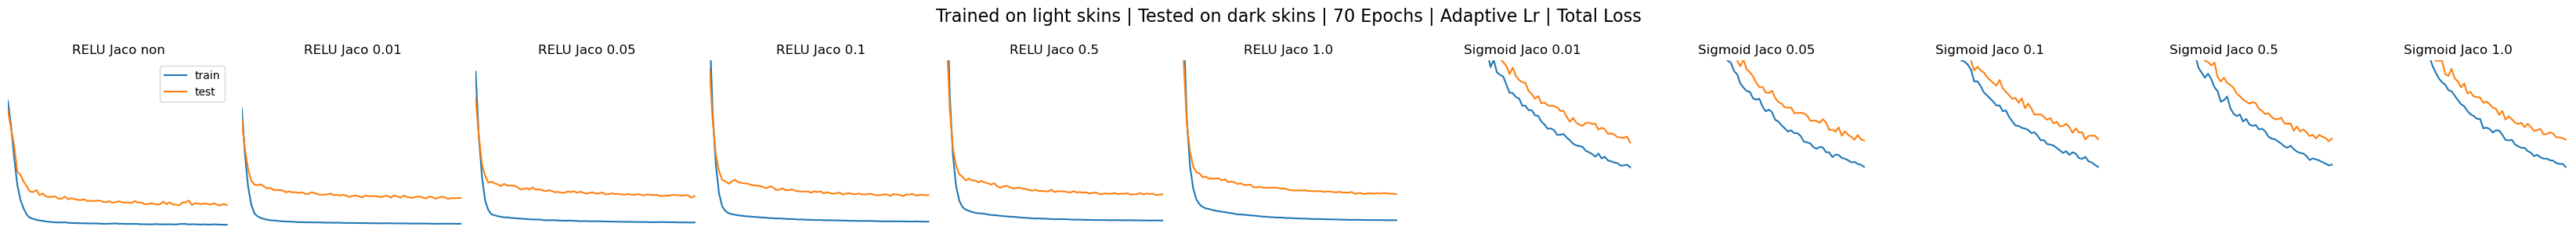

In [100]:
def get_total_loss(path):
    with open(path) as f:
        contents = f.readlines()
    train_loss_list = get_list(contents, 'train_loss')
    test_loss_list = get_list(contents, 'test_loss')
    return train_loss_list,  test_loss_list

def plot_total_loss_group():
    train_r30, test_r30 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r30/results.txt')
    train_r31, test_r31 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r31/results.txt')
    train_r32, test_r32 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r32/results.txt')
    train_r33, test_r33 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r33/results.txt')
    train_r34, test_r34 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r34/results.txt')
    train_r35, test_r35 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r35/results.txt')
    train_r36, test_r36 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r36/results.txt')
    train_r37, test_r37 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r37/results.txt')
    train_r38, test_r38 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r38/results.txt')
    train_r39, test_r39 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r39/results.txt')
    train_r310, test_r310 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r310/results.txt')

    fig, axs = plt.subplots(1, 11, figsize=(33, 3))

    # Titles for each diagram
    titles = [
        'RELU Jaco non', 'RELU Jaco 0.01', 'RELU Jaco 0.05', 'RELU Jaco 0.1', 'RELU Jaco 0.5', 'RELU Jaco 1.0',
        'Sigmoid Jaco 0.01', 'Sigmoid Jaco 0.05', 'Sigmoid Jaco 0.1', 'Sigmoid Jaco 0.5', 'Sigmoid Jaco 1.0'
        ]

    # Generate some sample data
    import numpy as np
    x = np.linspace(0, 1, 100)
    y = np.sin(2 * np.pi * x)

    # Loop through each subplot and plot the data

    axs[0].plot(train_r30, label='train')
    axs[0].plot(test_r30, label='test')
    axs[1].plot(train_r31)
    axs[1].plot(test_r31)
    axs[2].plot(train_r32)
    axs[2].plot(test_r32)
    axs[3].plot(train_r33)
    axs[3].plot(test_r33)
    axs[4].plot(train_r34)
    axs[4].plot(test_r34)
    axs[5].plot(train_r35)
    axs[5].plot(test_r35)
    axs[6].plot(train_r36)
    axs[6].plot(test_r36)
    axs[7].plot(train_r37)
    axs[7].plot(test_r37)
    axs[8].plot(train_r38)
    axs[8].plot(test_r38)
    axs[9].plot(train_r39)
    axs[9].plot(test_r39)
    axs[10].plot(train_r310)
    axs[10].plot(test_r310)

    for i, ax in enumerate(axs.flat):
        ax.set_title(titles[i])
        #ax.set_xlabel('X Axis')
        #ax.set_ylabel('Y Axis')
        #ax.set_xlim(0, 1)
        ax.set_ylim([0, 0.05])
        ax.set_xlim([0, 70])
        ax.axis("off")

    # Remove empty subplots
    #for i in range(22, len(axs.flat)):
    #    fig.delaxes(axs.flatten()[i])
    fig.suptitle('Trained on light skins | Tested on dark skins | 70 Epochs | Adaptive Lr | Total Loss', fontsize=16)
    plt.tight_layout()
    axs[0].legend()
    plt.show()
plot_total_loss_group()

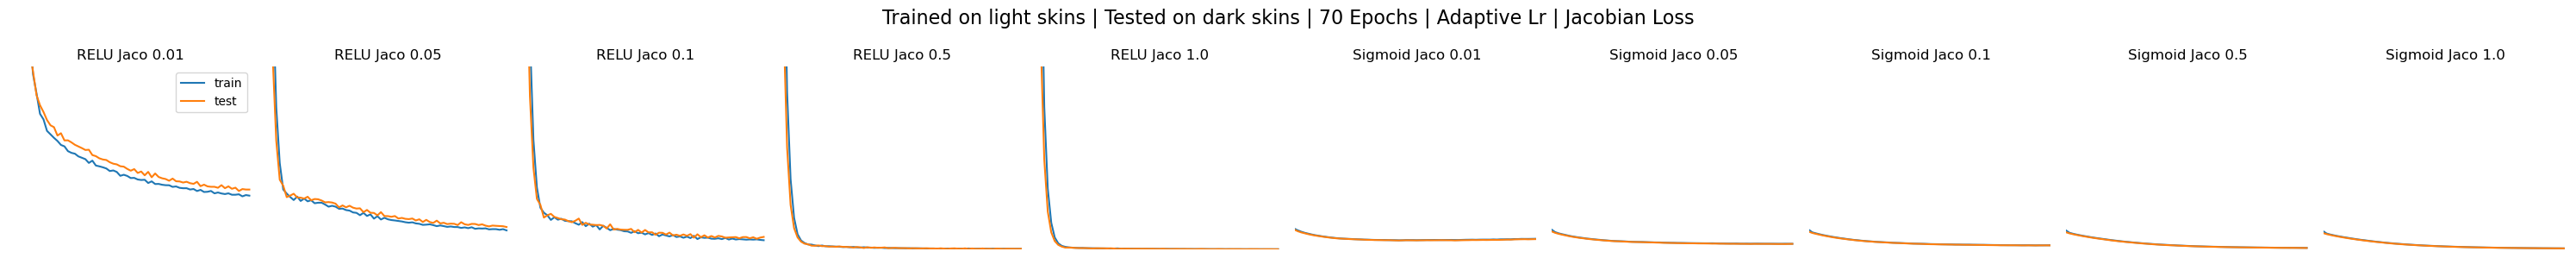

In [103]:
def get_jaco_loss(path):
    with open(path) as f:
        contents = f.readlines()
    train_loss_list = get_list(contents, 'jacobian_loss')
    test_loss_list = get_list(contents, 'test_jaco_loss')
    jaco_scale = float(contents[6][contents[6].index(':')+1:])
    return train_loss_list,  test_loss_list, jaco_scale

def plot_jaco_loss_group():
    train_r31, test_r31, _ = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r31/results.txt')
    train_r32, test_r32, _ = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r32/results.txt')
    train_r33, test_r33, _ = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r33/results.txt')
    train_r34, test_r34, _ = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r34/results.txt')
    train_r35, test_r35, _ = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r35/results.txt')
    train_r36, test_r36, _ = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r36/results.txt')
    train_r37, test_r37, _ = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r37/results.txt')
    train_r38, test_r38, _ = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r38/results.txt')
    train_r39, test_r39, _ = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r39/results.txt')
    train_r310, test_r310, _ = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r310/results.txt')

    fig, axs = plt.subplots(1, 10, figsize=(30, 3))

    # Titles for each diagram
    titles = [
        'RELU Jaco 0.01', 'RELU Jaco 0.05', 'RELU Jaco 0.1', 'RELU Jaco 0.5', 'RELU Jaco 1.0',
        'Sigmoid Jaco 0.01', 'Sigmoid Jaco 0.05', 'Sigmoid Jaco 0.1', 'Sigmoid Jaco 0.5', 'Sigmoid Jaco 1.0'
        ]

    # Generate some sample data
    import numpy as np
    x = np.linspace(0, 1, 100)
    y = np.sin(2 * np.pi * x)

    # Loop through each subplot and plot the data

    axs[0].plot(train_r31, label='train')
    axs[0].plot(test_r31, label='test')
    axs[1].plot(train_r32)
    axs[1].plot(test_r32)
    axs[2].plot(train_r33)
    axs[2].plot(test_r33)
    axs[3].plot(train_r34)
    axs[3].plot(test_r34)
    axs[4].plot(train_r35)
    axs[4].plot(test_r35)
    axs[5].plot(train_r36)
    axs[5].plot(test_r36)
    axs[6].plot(train_r37)
    axs[6].plot(test_r37)
    axs[7].plot(train_r38)
    axs[7].plot(test_r38)
    axs[8].plot(train_r39)
    axs[8].plot(test_r39)
    axs[9].plot(train_r310)
    axs[9].plot(test_r310)

    for i, ax in enumerate(axs.flat):
        ax.set_title(titles[i])
        #ax.set_xlabel('X Axis')
        #ax.set_ylabel('Y Axis')
        #ax.set_xlim(0, 1)
        ax.set_ylim([0, 0.05])
        ax.set_xlim([0, 70])
        ax.axis("off")

    # Remove empty subplots
    #for i in range(22, len(axs.flat)):
    #    fig.delaxes(axs.flatten()[i])
    fig.suptitle('Trained on light skins | Tested on dark skins | 70 Epochs | Adaptive Lr | Jacobian Loss', fontsize=16)
    plt.tight_layout()
    axs[0].legend()
    plt.show()
plot_jaco_loss_group()

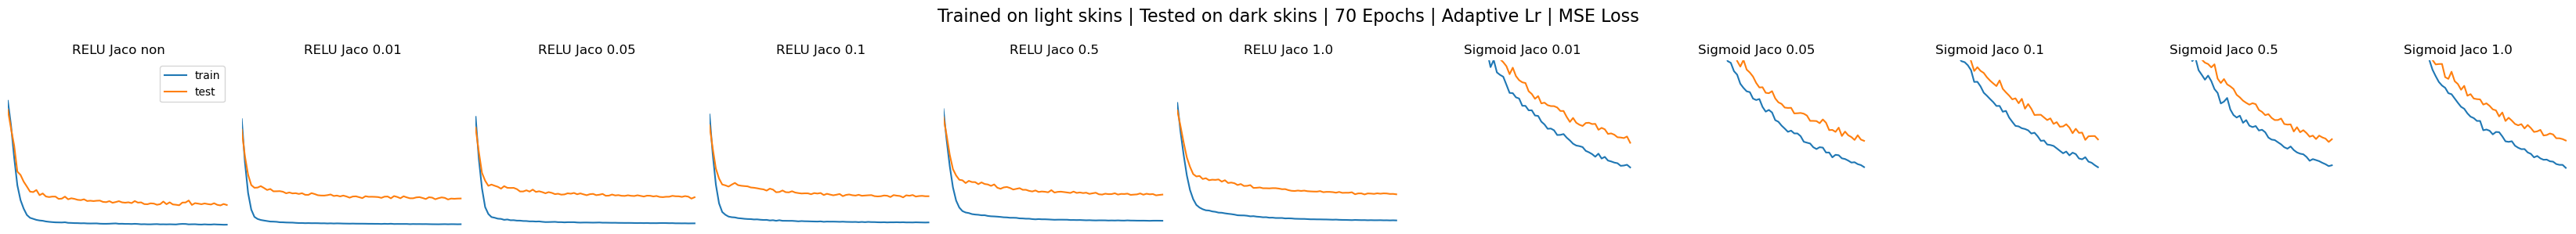

In [104]:
def plot_mse_loss_group():
    train_r30, test_r30 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r30/results.txt')
    train_r31, test_r31 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r31/results.txt')
    train_r32, test_r32 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r32/results.txt')
    train_r33, test_r33 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r33/results.txt')
    train_r34, test_r34 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r34/results.txt')
    train_r35, test_r35 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r35/results.txt')
    train_r36, test_r36 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r36/results.txt')
    train_r37, test_r37 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r37/results.txt')
    train_r38, test_r38 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r38/results.txt')
    train_r39, test_r39 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r39/results.txt')
    train_r310, test_r310 = get_total_loss('D:/GitHub/FAU_Dataset/code/results_r310/results.txt')

    train_j_r31, test_j_r31, j_scale_r31 = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r31/results.txt')
    train_j_r32, test_j_r32, j_scale_r32 = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r32/results.txt')
    train_j_r33, test_j_r33, j_scale_r33 = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r33/results.txt')
    train_j_r34, test_j_r34, j_scale_r34 = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r34/results.txt')
    train_j_r35, test_j_r35, j_scale_r35 = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r35/results.txt')
    train_j_r36, test_j_r36, j_scale_r36 = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r36/results.txt')
    train_j_r37, test_j_r37, j_scale_r37 = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r37/results.txt')
    train_j_r38, test_j_r38, j_scale_r38 = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r38/results.txt')
    train_j_r39, test_j_r39, j_scale_r39 = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r39/results.txt')
    train_j_r310, test_j_r310, j_scale_r310 = get_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r310/results.txt')

    fig, axs = plt.subplots(1, 11, figsize=(33, 3))

    # Titles for each diagram
    titles = [
        'RELU Jaco non', 'RELU Jaco 0.01', 'RELU Jaco 0.05', 'RELU Jaco 0.1', 'RELU Jaco 0.5', 'RELU Jaco 1.0',
        'Sigmoid Jaco 0.01', 'Sigmoid Jaco 0.05', 'Sigmoid Jaco 0.1', 'Sigmoid Jaco 0.5', 'Sigmoid Jaco 1.0'
        ]

    # Generate some sample data
    import numpy as np
    x = np.linspace(0, 1, 100)
    y = np.sin(2 * np.pi * x)

    # Loop through each subplot and plot the data

    axs[0].plot(train_r30, label='train')
    axs[0].plot(test_r30, label='test')
    axs[1].plot(np.array(train_r31)-j_scale_r31*np.array(train_j_r31))
    axs[1].plot(np.array(test_r31)-j_scale_r31*np.array(test_j_r31))
    axs[2].plot(np.array(train_r32)-j_scale_r32*np.array(train_j_r32))
    axs[2].plot(np.array(test_r32)-j_scale_r32*np.array(test_j_r32))
    axs[3].plot(np.array(train_r33)-j_scale_r33*np.array(train_j_r33))
    axs[3].plot(np.array(test_r33)-j_scale_r33*np.array(test_j_r33))
    axs[4].plot(np.array(train_r34)-j_scale_r34*np.array(train_j_r34))
    axs[4].plot(np.array(test_r34)-j_scale_r34*np.array(test_j_r34))
    axs[5].plot(np.array(train_r35)-j_scale_r35*np.array(train_j_r35))
    axs[5].plot(np.array(test_r35)-j_scale_r35*np.array(test_j_r35))
    axs[6].plot(np.array(train_r36)-j_scale_r36*np.array(train_j_r36))
    axs[6].plot(np.array(test_r36)-j_scale_r36*np.array(test_j_r36))
    axs[7].plot(np.array(train_r37)-j_scale_r37*np.array(train_j_r37))
    axs[7].plot(np.array(test_r37)-j_scale_r37*np.array(test_j_r37))
    axs[8].plot(np.array(train_r38)-j_scale_r38*np.array(train_j_r38))
    axs[8].plot(np.array(test_r38)-j_scale_r38*np.array(test_j_r38))
    axs[9].plot(np.array(train_r39)-j_scale_r39*np.array(train_j_r39))
    axs[9].plot(np.array(test_r39)-j_scale_r39*np.array(test_j_r39))
    axs[10].plot(np.array(train_r310)-j_scale_r310*np.array(train_j_r310))
    axs[10].plot(np.array(test_r310)-j_scale_r310*np.array(test_j_r310))

    for i, ax in enumerate(axs.flat):
        ax.set_title(titles[i])
        #ax.set_xlabel('X Axis')
        #ax.set_ylabel('Y Axis')
        #ax.set_xlim(0, 1)
        ax.set_ylim([0, 0.05])
        ax.set_xlim([0, 70])
        ax.axis("off")

    # Remove empty subplots
    #for i in range(22, len(axs.flat)):
    #    fig.delaxes(axs.flatten()[i])
    fig.suptitle('Trained on light skins | Tested on dark skins | 70 Epochs | Adaptive Lr | MSE Loss', fontsize=16)
    plt.tight_layout()
    axs[0].legend()
    plt.show()
plot_mse_loss_group()

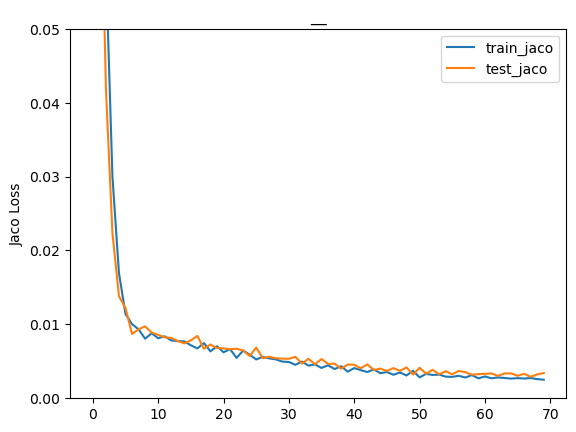

In [64]:
plot_jaco_loss('D:/GitHub/FAU_Dataset/code/results_r33/results.txt', '__')

[0.06138786686227677, 0.033823223951015065, 0.01842295045548297, 0.009898989314728594, 0.005977687049419322, 0.004581013242615031, 0.003900690566986165, 0.0036416802000492176, 0.0034421019414637953, 0.0033043096357203545, 0.0031531389881955816, 0.003065314080486906, 0.002942365820103503, 0.0029060419094055255, 0.0027954822525064994, 0.002771913910165746, 0.0026202828009077844, 0.002626472568892418, 0.0025320537071278756, 0.0024317874077786792, 0.00242655892321404, 0.0022938676891808814, 0.002347208511956195, 0.0022713796651743826, 0.002212980215219741, 0.0021338594958503197, 0.0021736599425686166, 0.00208770585979553, 0.0019893929283035564, 0.0020352127149384073, 0.0019780235642448385, 0.0019247962122267866, 0.0019361155543555606, 0.0018565544105590658, 0.0018530919196757866, 0.0018578791475676476, 0.0017718618220471322, 0.0017841394039544653, 0.00180552805516314, 0.0017370931170088179, 0.0017624826348842458, 0.00169754277994024, 0.0017140349809159623, 0.0016927415306897875, 0.00161980

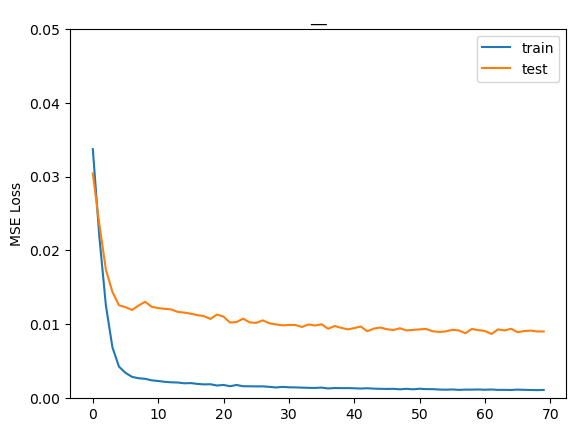

In [69]:
plot_mse_loss('D:/GitHub/FAU_Dataset/code/results_r33/results.txt', '__')

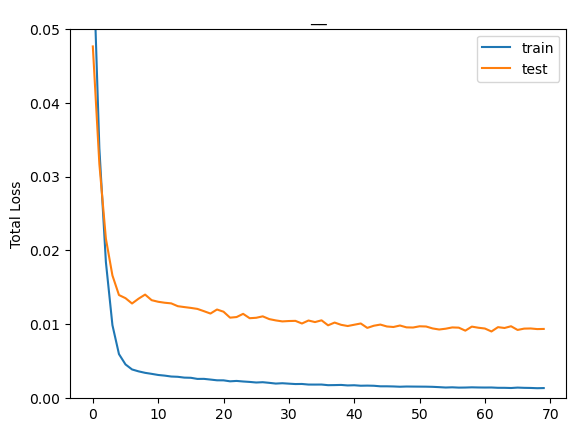

In [65]:
plot_total_loss('D:/GitHub/FAU_Dataset/code/results_r33/results.txt', '__')